In [1]:
import deepjr.twoNodeJRsim 


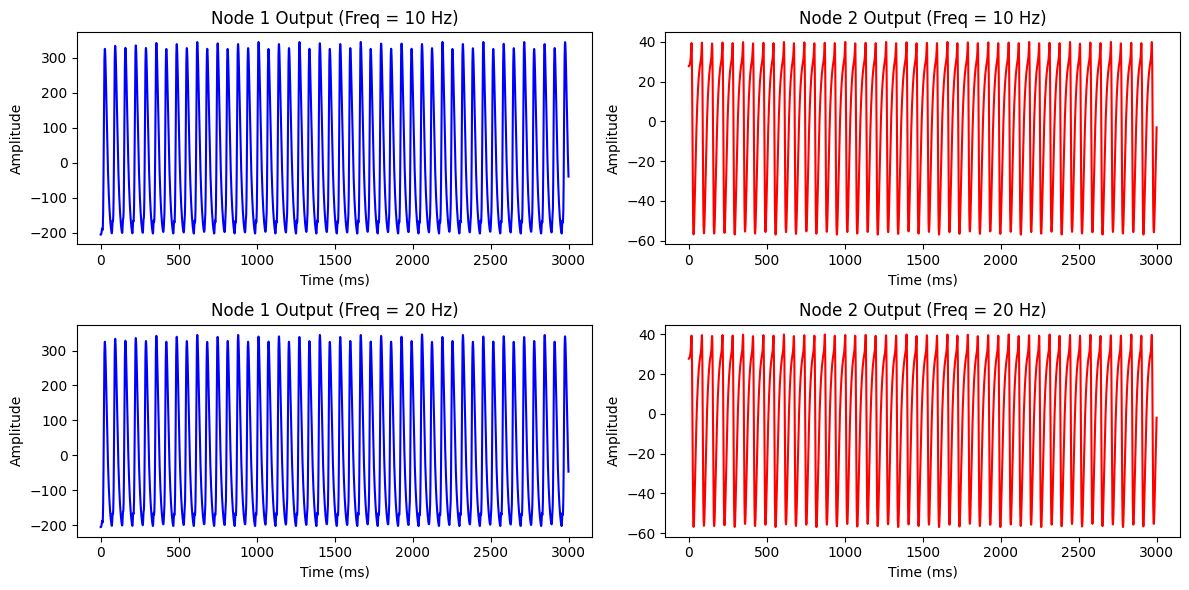

In [2]:
sim_lfp =  deepjr.twoNodeJRsim.simulate_jr_model(F=[10, 20], stim_time=100, Tbase=20, Ttot=30, dt=0.01, seed=42)
deepjr.twoNodeJRsim.plot_simulation(sim_lfp, dt=1)


Reading forward solution from /Users/deepatilwani/Documents/Phd_projects/DCM/Jansen-Rit-Model-Benchmarking-Deep-Learning/notebooks/fsaverage-fwd.fif.gz...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read EEG forward solution (8196 sources, 64 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


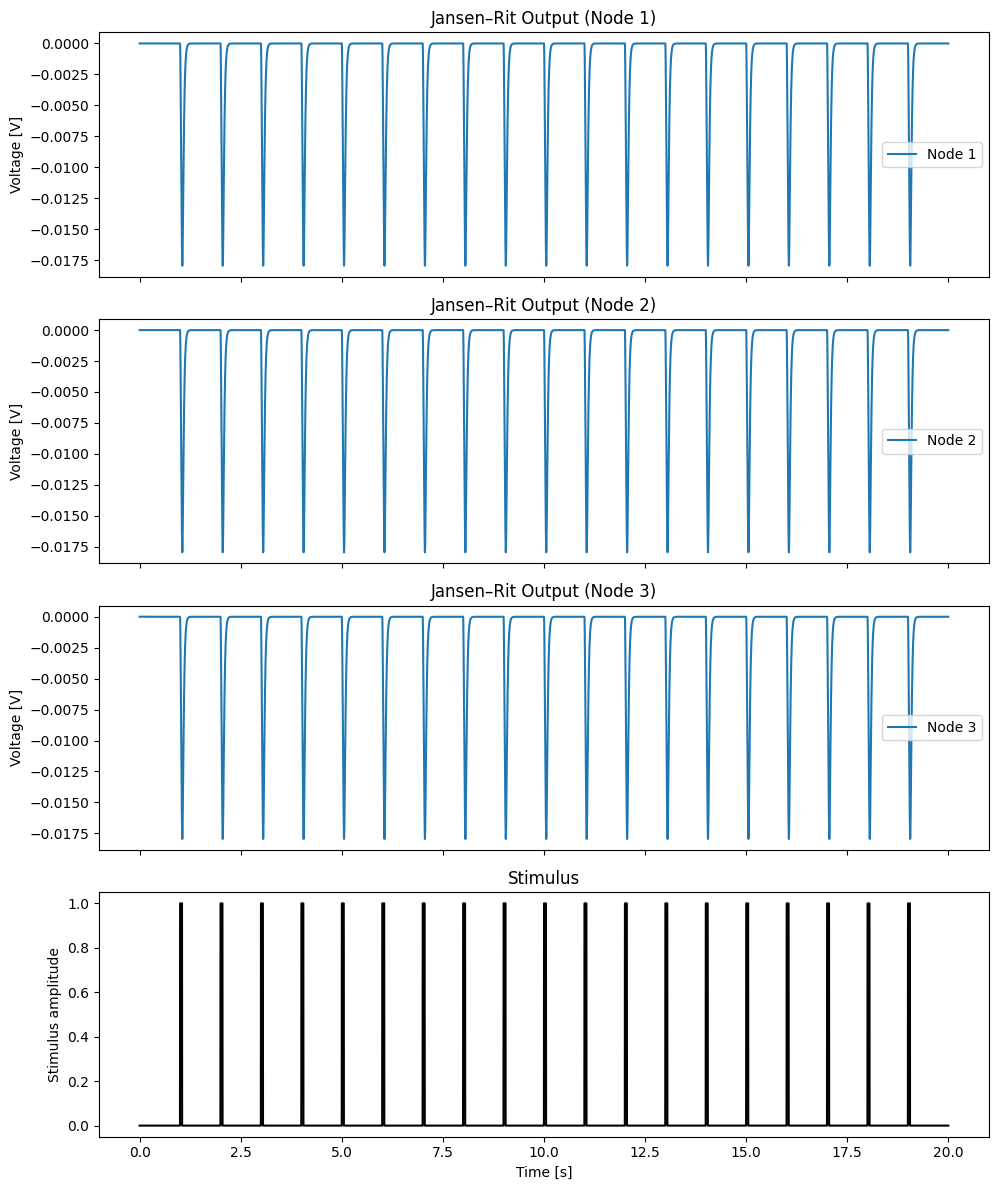

Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 0 labels from /Users/deepatilwani/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 1 labels from /Users/deepatilwani/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Reading labels from parcellation...
   read 1 labels from /Users/deepatilwani/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 0 labels from /Users/deepatilwani/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information not stored
    Interval 0.000–1.000 s
Setting up forward solutions
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    In

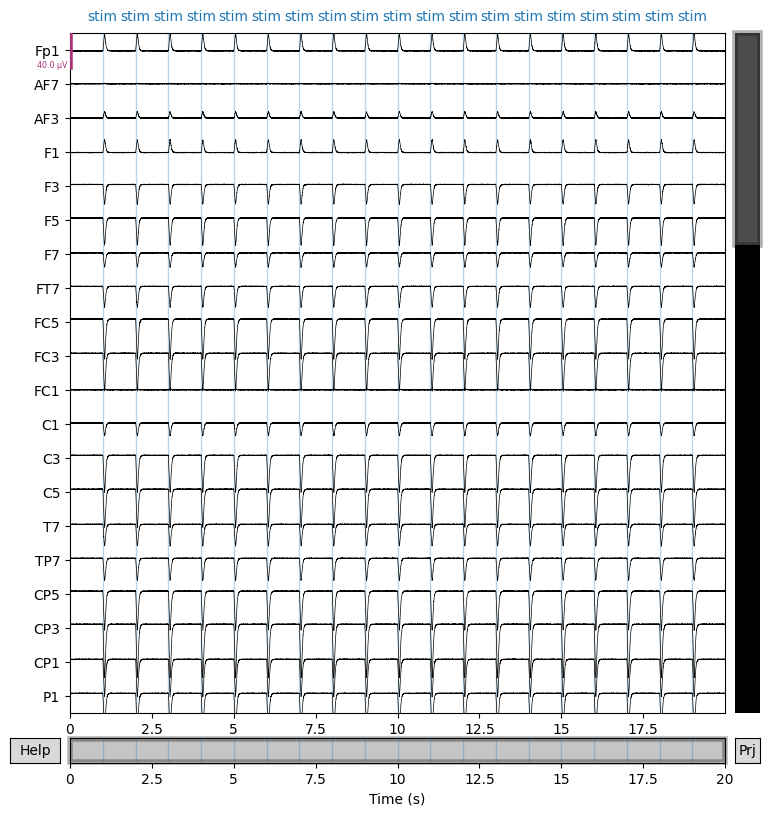

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import xarray as xr
from frozendict import frozendict
from deepjr.simulation import SourceSimulator
from pathlib import Path

# Import helper functions from simulation.py
from deepjr.simulation import get_fsaverage_fwd, generate_events, generate_stimulus, run_jr_simulation

# Default Jansen–Rit parameters
jr_typical_param = frozendict({
    "A_e": 3.25 * 1e-3,
    "A_i": 22 * 1e-3,
    "b_e": 100,
    "b_i": 50,
    "C": 135,
    "a_1": 1.0,
    "a_2": 0.8,
    "a_3": 0.25,
    "a_4": 0.25,
    "v_max": 50 * 1e-3,
    "v_0": 6 * 1e-3
})

class EEGSimulator:
    """
    EEGSimulator combines a Jansen–Rit simulation (using helper functions from simulation.py)
    with EEG sensor projection via MNE’s SourceSimulator. This version allows simulating multiple
    nodes (sources) whose outputs can be mapped to multiple target regions.

    Parameters
    ----------
    sfreq : float
        Sampling frequency in Hz.
    montage : str or instance of DigMontage
        The montage to use (e.g., 'biosemi64').
    subject : str
        Subject name (default "fsaverage").
    subjects_dir : str or None
        Path to subjects directory (if needed).
    noise_fact : float or None
        Scaling factor for added noise during EEG simulation.
    """
    def __init__(self, sfreq=1000, montage='biosemi64', subject="fsaverage", subjects_dir=None, noise_fact=None):
        self.sfreq = sfreq
        if isinstance(montage, str):
            self.montage = mne.channels.make_standard_montage(montage)
        else:
            self.montage = montage
        self.info = mne.create_info(self.montage.ch_names, sfreq, ch_types="eeg")
        self.info.set_montage(self.montage)
        self.subject = subject
        self.subjects_dir = subjects_dir
        self.noise_fact = noise_fact
        self.noise_cov = mne.make_ad_hoc_cov(self.info)
        if subject == "fsaverage":
            self.fwd = get_fsaverage_fwd(self.info)
        else:
            raise NotImplementedError("Currently only fsaverage is supported.")
    
    @property
    def dt(self):
        return 1.0 / self.sfreq

    def simulate_jr(self, t_tot=3.0, t_base=1.0, pulse_width_fraction=0.05,
                    n_nodes=1, jr_params={}, jr_noise_sd=0.0, seed=None):
        """
        Run a simulation of the Jansen–Rit model for multiple nodes.

        Parameters
        ----------
        t_tot : float
            Total simulation time in seconds.
        t_base : float
            Baseline duration (in seconds) before stimulus onset.
        pulse_width_fraction : float
            Fraction of each cycle in which the stimulus is high.
        n_nodes : int
            Number of independent nodes (sources) to simulate.
        jr_params : dict
            Dictionary to update JR parameters (overrides defaults).
        jr_noise_sd : float
            Standard deviation for added noise.
        seed : int or None
            Random seed.

        Returns
        -------
        output : ndarray, shape (n_nodes, nb_samples)
            The simulated model outputs for each node (defined as y[1]-y[2]).

        To do :  
        1. Introduce the delay for the connections of the nodes (convulation delay, check delay with neural ode)
        2. Connectivity matrix between the regions
        3. Global parms connectivity to be predicted. 

        """
        if seed is not None:
            np.random.seed(seed)
        # Generate events and stimulus (common to all nodes)
        events = generate_events(inter_trial_freq=1.0, dt=self.dt, t_base=t_base, t_tot=t_tot)
        I, Ip, Ii, t = generate_stimulus(self.dt, t_tot, events,
                                           pulse_width_fraction=pulse_width_fraction, return_time=True)
        nb_samples = len(Ip)
        outputs = []
        # Simulate each node independently using the same stimulus but different noise
        for i in range(n_nodes):
            if jr_noise_sd > 0:
                noise = jr_noise_sd * np.random.randn(nb_samples)
            else:
                noise = np.zeros(nb_samples)
            params = dict(jr_typical_param)
            params.update(jr_params)
            # run_jr_simulation returns a 6 x nb_samples array for one node
            y = run_jr_simulation(self.dt, Ii, Ip, noise, params)
            # Define node output as the difference between excitatory and inhibitory activity
            outputs.append(y[1] - y[2])
        # Stack outputs into an array of shape (n_nodes, nb_samples)
        self.output = np.vstack(outputs)
        self.sim_time = t
        self.events = events
        self.stimulus = I
        return self.output

    def compute_raw_from_output(self, output, target_region, location="center",
                                extent=10.0, gain=1e-6, seed=0, verbose=None):
        """
        Compute raw EEG from the simulated outputs using MNE’s SourceSimulator.

        Parameters
        ----------
        output : ndarray, shape (n_nodes, nb_samples)
            Simulated time series from each node (in Volts).
        target_region : str or list of str
            If multiple nodes are simulated, provide a list of target regions (one per node).
            If a single string is provided, it is used for all nodes.
        location : str
            Source selection criteria (e.g., "center").
        extent : float
            Spatial extent (mm) for selecting sources.
        gain : float
            Scaling factor applied to the simulated output.
        seed : int
            Random seed for noise.
        verbose : bool or None
            Verbosity flag.

        Returns
        -------
        raw : instance of mne.io.Raw
            The simulated raw EEG data.
        raw_snr : float
            Estimated signal-to-noise ratio (dB); NaN if no noise was added.
        """
        if not hasattr(self, "events"):
            raise RuntimeError("No simulation events found. Run simulate_jr() first.")
        n_nodes = output.shape[0]
        # If a single region is provided, replicate it for all nodes.
        if isinstance(target_region, str):
            target_region = [target_region] * n_nodes
        elif len(target_region) != n_nodes:
            raise ValueError("Length of target_region list must equal n_nodes.")
        
        event_for_source = [[0, 0, 0]]
        source_simulator = SourceSimulator(self.fwd["src"], tstep=self.dt)
        # Loop over nodes and add each node's data to the source simulator.
        for i in range(n_nodes):
            # Select label for the current node.
            label_kwargs = dict(regexp=target_region[i], subjects_dir=self.subjects_dir, verbose=verbose)
            labels = mne.read_labels_from_annot(self.subject, **label_kwargs)
            if len(labels) == 0:
                raise RuntimeError(f"No labels found for target region: {target_region[i]}")
            selected_label = labels[0]
            label = mne.label.select_sources(self.subject, selected_label, location=location, extent=extent)
            # Add the node's output (1D array) to the simulator.
            node_data = np.asarray(output[i])
            source_simulator.add_data(label, gain * node_data, event_for_source)
        
        # Generate raw EEG using the forward solution.
        raw = mne.simulation.simulate_raw(self.info, source_simulator, forward=self.fwd, verbose=verbose)
        raw.set_eeg_reference(projection=True, verbose=verbose)
        raw_clean = raw.copy()
        if self.noise_fact:
            noise_cov = self.noise_cov.copy()
            noise_cov['data'] = noise_cov.data * self.noise_fact
            mne.simulation.add_noise(raw, cov=noise_cov, random_state=seed)
            
            signal_power = np.mean(raw_clean.get_data() ** 2)
            noise_power = np.mean((raw.get_data() - raw_clean.get_data()) ** 2)
            raw_snr = 10 * np.log10(signal_power / noise_power)
        else:
            raw_snr = np.nan
        raw.pick('eeg')
        annotations = mne.annotations_from_events(self.events, self.info["sfreq"], {0: "stim"}, verbose=verbose)
        raw.set_annotations(annotations, verbose=verbose)
        return raw, raw_snr

    def simulate_eeg(self, target_region, location="center", extent=10.0,
                     gain=1e-6, seed=0, verbose=None):
        """
        Compute raw EEG from the JR simulation outputs.

        Parameters
        ----------
        target_region : str or list of str
            Target region(s) for projection. If multiple nodes were simulated,
            provide a list (one per node).
        location : str
            Source selection criteria.
        extent : float
            Spatial extent (mm) for source selection.
        gain : float
            Scaling gain applied to the simulated output.
        seed : int
            Random seed for noise.
        verbose : bool or None
            Verbosity flag.

        Returns
        -------
        raw : instance of mne.io.Raw
            Simulated raw EEG data.
        raw_snr : float
            Estimated signal-to-noise ratio.
        """
        if not hasattr(self, "output"):
            raise RuntimeError("No JR simulation output found. Run simulate_jr() first.")
        raw, raw_snr = self.compute_raw_from_output(self.output, target_region,
                                                    location, extent, gain, seed, verbose)
        self.raw = raw
        self.raw_snr = raw_snr
        return raw, raw_snr

    def plot_simulation(self):
        """
        Plot the JR simulation output (for each node) and the stimulus.
        """
        if not hasattr(self, "sim_time"):
            raise RuntimeError("No simulation data to plot. Run simulate_jr() first.")
        n_nodes = self.output.shape[0]
        fig, axes = plt.subplots(n_nodes+1, 1, figsize=(10, 3*(n_nodes+1)), sharex=True)
        for i in range(n_nodes):
            axes[i].plot(self.sim_time, self.output[i], label=f"Node {i+1}")
            axes[i].set_ylabel("Voltage [V]")
            axes[i].set_title(f"Jansen–Rit Output (Node {i+1})")
            axes[i].legend()
        axes[-1].plot(self.sim_time, self.stimulus, color='k')
        axes[-1].set_title("Stimulus")
        axes[-1].set_xlabel("Time [s]")
        axes[-1].set_ylabel("Stimulus amplitude")
        plt.tight_layout()
        plt.show()


# --- Example usage ---
if __name__ == '__main__':
    # simulate 3 nodes and project them to 3 different target regions.
    target_regions = ["caudalmiddlefrontal-lh", "parsopercularis-rh", "superiorparietal-lh"]
    n_nodes = len(target_regions)

    # Instantiate the EEG simulator.
    eeg_sim = EEGSimulator(sfreq=1000, montage='biosemi64', subject="fsaverage", subjects_dir=None, noise_fact=1)
    
    # Run the Jansen–Rit simulation for 3 seconds (with 1 second baseline) for n_nodes.
    eeg_sim.simulate_jr(t_tot=20, t_base=1.0, pulse_width_fraction=0.05,
                        n_nodes=n_nodes, jr_params={}, jr_noise_sd=0.0, seed=42)
    
    # Plot the simulation outputs for all nodes.
    eeg_sim.plot_simulation()
    
    # Compute raw EEG from the simulated outputs using the provided target regions.
    raw_eeg, raw_snr = eeg_sim.simulate_eeg(target_region=target_regions,
                                            location="center", extent=10.0,
                                            gain=1e-6, seed=42, verbose=True)
    print("Raw EEG SNR (dB):", raw_snr)
    
    # Use MNE's interactive plot for further inspection.
    raw_eeg.plot(duration=30, start=0)
